In [1]:
import keras
keras.__version__

'2.13.1'

In [2]:
import os

data_dir = 'C:/Users/danij/Desktop/Practica/Carte'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
#Convertim cele 420551 de linii intr-un vector Numpy
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

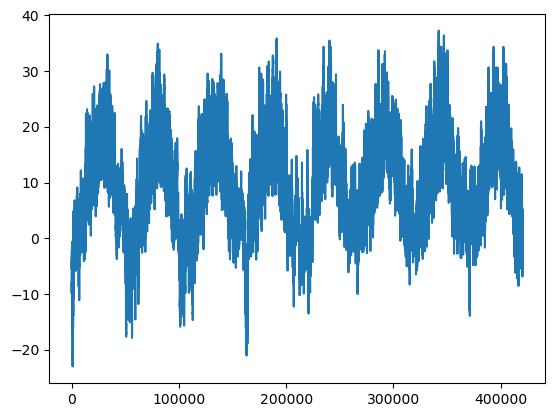

In [4]:
#Plotam pentru a vedea temperatura in Celsius in timp
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

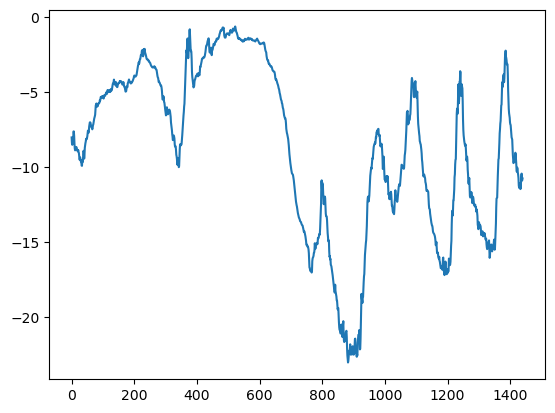

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
#Utilizam  functia generator pentru a instanta 3 generatori: pentru antrenare (primele 200000 de momente), validare (urm. 100000) 
#si testare (cele ramanse).
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Cati pasi luam din `val_gen` pentru a vedea intregul set de validare:
val_steps = (300000 - 200001 - lookback) // batch_size

# Cati pasi luam din `test_gen` pentru a vedea intregul set de testare:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [10]:
#Loop pentru evaluare
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


C:\Users\danij\AppData\Local\Temp\ipykernel_17484\3204401368.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 12s 23ms/step - loss: 1.1573 - val_loss: 0.5357
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3888 - val_loss: 0.3388
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2902 - val_loss: 0.3244
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2651 - val_loss: 0.3749
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2544 - val_loss: 0.3087
Epoch 6/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2461 - val_loss: 0.3178
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2383 - val_loss: 0.3182
Epoch 8/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2332 - val_loss: 0.3423
Epoch 9/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2293 - val_loss: 0.3470
Epoch 10/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2242 - val_los

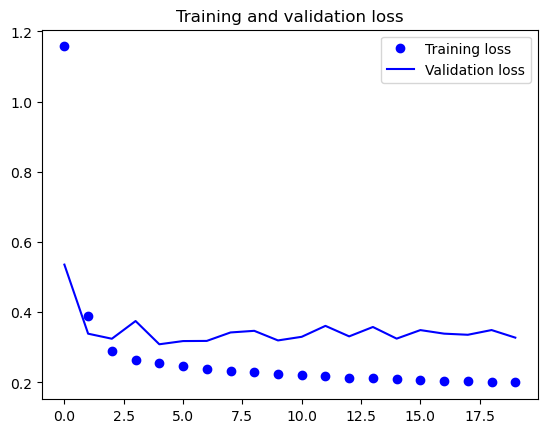

In [12]:
#Afisam pierderile la validare si antrenare
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


C:\Users\danij\AppData\Local\Temp\ipykernel_17484\2161899563.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 74s 144ms/step - loss: 0.3105 - val_loss: 0.2743
Epoch 2/20
500/500 [==============================] - 72s 144ms/step - loss: 0.2849 - val_loss: 0.2700
Epoch 3/20
500/500 [==============================] - 71s 143ms/step - loss: 0.2790 - val_loss: 0.2632
Epoch 4/20
500/500 [==============================] - 71s 142ms/step - loss: 0.2741 - val_loss: 0.2651
Epoch 5/20
500/500 [==============================] - 70s 140ms/step - loss: 0.2695 - val_loss: 0.2641
Epoch 6/20
500/500 [==============================] - 70s 140ms/step - loss: 0.2647 - val_loss: 0.2628
Epoch 7/20
500/500 [==============================] - 73s 146ms/step - loss: 0.2600 - val_loss: 0.2686
Epoch 8/20
500/500 [==============================] - 72s 143ms/step - loss: 0.2554 - val_loss: 0.2674
Epoch 9/20
500/500 [==============================] - 72s 145ms/step - loss: 0.2512 - val_loss: 0.2637
Epoch 10/20
500/500 [==============================] - 71s 142ms/step - loss: 0.2459

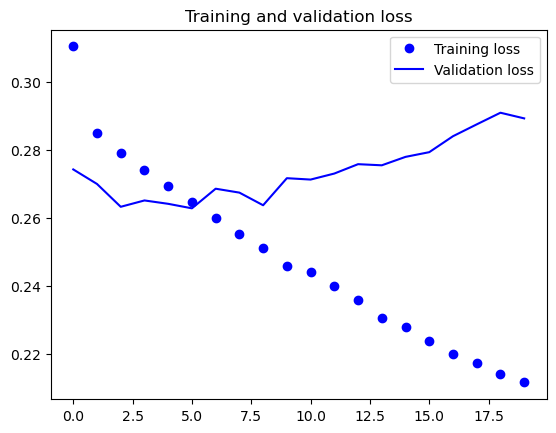

In [14]:
#Rezultatele
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 103s 201ms/step - loss: 0.3319 - val_loss: 0.2776
Epoch 2/40
500/500 [==============================] - 102s 203ms/step - loss: 0.3095 - val_loss: 0.2783
Epoch 3/40
500/500 [==============================] - 95s 191ms/step - loss: 0.2997 - val_loss: 0.2811
Epoch 4/40
500/500 [==============================] - 96s 192ms/step - loss: 0.2973 - val_loss: 0.2762
Epoch 5/40
500/500 [==============================] - 95s 191ms/step - loss: 0.2928 - val_loss: 0.2719
Epoch 6/40
500/500 [==============================] - 96s 193ms/step - loss: 0.2881 - val_loss: 0.2703
Epoch 7/40
500/500 [==============================] - 95s 191ms/step - loss: 0.2857 - val_loss: 0.2709
Epoch 8/40
500/500 [==============================] - 99s 198ms/step - loss: 0.2786 - val_loss: 0.2754
Epoch 9/40
500/500 [==============================] - 101s 203ms/step - loss: 0.2766 - val_loss: 0.2827
Epoch 10/40
500/500 [==============================] - 100s 200ms/step

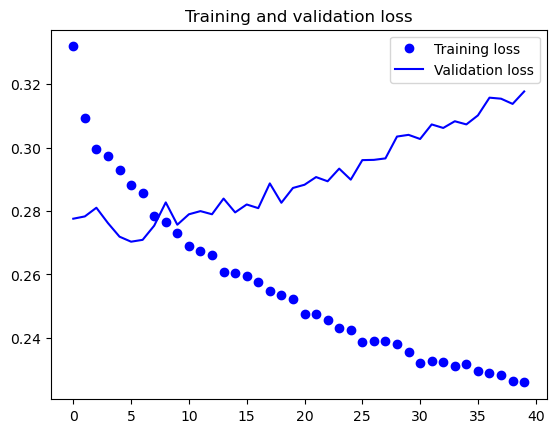

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=50,
                              epochs=4,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/4
50/50 [==============================] - 85s 2s/step - loss: 0.3818 - val_loss: 0.2954
Epoch 2/4
50/50 [==============================] - 80s 2s/step - loss: 0.3271 - val_loss: 0.2863
Epoch 3/4
50/50 [==============================] - 79s 2s/step - loss: 0.3215 - val_loss: 0.2921
Epoch 4/4
50/50 [==============================] - 78s 2s/step - loss: 0.3188 - val_loss: 0.2941


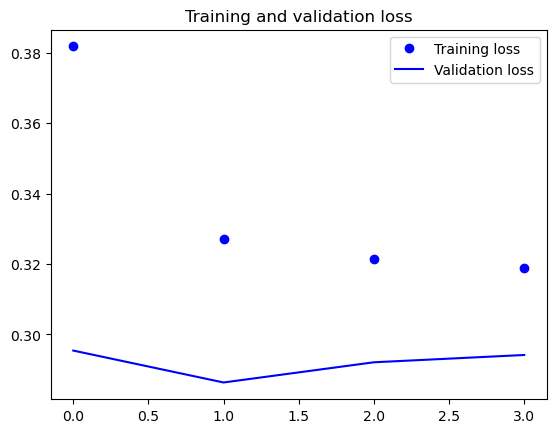

In [19]:
#Rezultate
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [21]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen_reverse,
                              steps_per_epoch=50,
                              epochs=2,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/2
50/50 [==============================] - 32s 615ms/step - loss: 0.5235 - val_loss: 0.4898
Epoch 2/2
50/50 [==============================] - 30s 606ms/step - loss: 0.4864 - val_loss: 0.4908


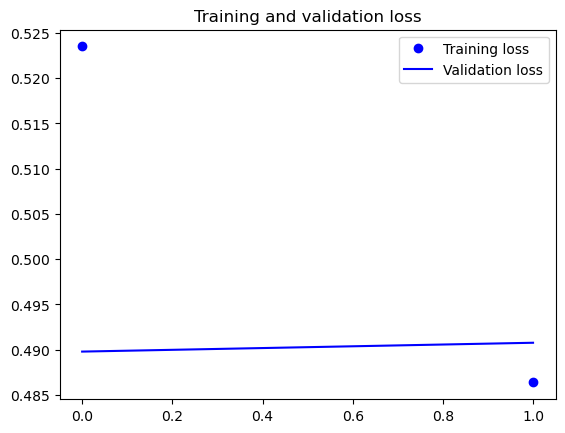

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Numarul de cuvinte ca si caracteristici
max_features = 10000

maxlen = 500

# Incarcam datele
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Scvente inverse
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Secvente de pad
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=3,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/3
157/157 [==============================] - 67s 417ms/step - loss: 0.6009 - acc: 0.6635 - val_loss: 0.4125 - val_acc: 0.8342
Epoch 2/3
157/157 [==============================] - 64s 410ms/step - loss: 0.3976 - acc: 0.8384 - val_loss: 0.3580 - val_acc: 0.8546
Epoch 3/3
157/157 [==============================] - 64s 411ms/step - loss: 0.3170 - acc: 0.8780 - val_loss: 0.3642 - val_acc: 0.8504


In [24]:
from keras import backend as K
K.clear_session()

In [25]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 93s 569ms/step - loss: 0.6663 - acc: 0.5714 - val_loss: 0.5563 - val_acc: 0.7388
Epoch 2/10
157/157 [==============================] - 89s 567ms/step - loss: 0.4476 - acc: 0.8080 - val_loss: 0.3520 - val_acc: 0.8670
Epoch 3/10
157/157 [==============================] - 88s 563ms/step - loss: 0.3274 - acc: 0.8762 - val_loss: 0.3573 - val_acc: 0.8528
Epoch 4/10
157/157 [==============================] - 88s 558ms/step - loss: 0.2722 - acc: 0.8977 - val_loss: 0.3236 - val_acc: 0.8688
Epoch 5/10
157/157 [==============================] - 87s 555ms/step - loss: 0.2371 - acc: 0.9157 - val_loss: 0.3525 - val_acc: 0.8660
Epoch 6/10
157/157 [==============================] - 87s 553ms/step - loss: 0.2101 - acc: 0.9259 - val_loss: 0.3190 - val_acc: 0.8812
Epoch 7/10
157/157 [==============================] - 87s 553ms/step - loss: 0.1882 - acc: 0.9338 - val_loss: 0.3558 - val_acc: 0.8842
Epoch 8/10
157/157 [==============================] - 8

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=50,
                              epochs=4,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/4
50/50 [==============================] - 45s 841ms/step - loss: 0.3414 - val_loss: 0.2927
Epoch 2/4
50/50 [==============================] - 42s 850ms/step - loss: 0.2989 - val_loss: 0.2844
Epoch 3/4
50/50 [==============================] - 41s 843ms/step - loss: 0.2963 - val_loss: 0.2813
Epoch 4/4
50/50 [==============================] - 41s 832ms/step - loss: 0.2897 - val_loss: 0.2793
